# 04. Análisis Financiero y Optimización de Umbrales

## Objetivo del Notebook

Este notebook es el análisis principal del TFG y utiliza los módulos `.py` (`load_data`, `train_model`, `evaluate`) proporcionados.

El objetivo es ir más allá de las métricas proxy (como AUPRC o F1-Score) y **evaluar los modelos en base a su impacto financiero real**. Para ello:

1.  Se utiliza la estrategia de **Coste Variable (`sample_weight`)** basada en el `Amount` del fraude.
2.  Se utiliza la **función de coste (`expected_cost`)** que define un coste monetario para Falsos Negativos (90% del importe) y Falsos Positivos (5€ de inspección).
3.  Se optimiza el `amount_factor` (cuánto penalizar el importe) y el **umbral de decisión** para encontrar la configuración que minimice el coste financiero total en euros.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Importar las funciones personalizadas de los ficheros .py
# (Asegúrate de que la carpeta 'src' esté en el mismo directorio que este notebook)
from src.load_data import load_fraud_csv
from src.train_model import train_rf_with_cost, train_xgb_with_cost
from src.evaluate import expected_cost, best_threshold_by_cost, print_metrics

print("Módulos y librerías cargados.")

Módulos y librerías cargados.


## 1. Carga y División de Datos

Cargamos el dataset `creditcard.csv` usando la función `load_fraud_csv`. Esta función ya nos informa del ratio de fraude y el importe total en riesgo.

Luego, dividimos los datos en 80% entrenamiento y 20% prueba (siguiendo el script `compare_models.py`). Es crucial separar `amount_train` y `amount_test`, ya que los importes del set de prueba se usarán *solo* para la evaluación final.

In [5]:
from sklearn.datasets import fetch_openml
from pathlib import Path

# --- PASO 1: Descargar los datos de OpenML ---
print("Descargando dataset 'Credit Card Fraud' (ID 1597) desde OpenML...")
try:
    data = fetch_openml(data_id=1597, as_frame=True, parser='auto')
    
    # Combinar X e y en un solo DataFrame
    X = data.data
    y = data.target
    df = X.copy()
    
    # Mapear la clase objetivo a 0 (Normal) y 1 (Fraude) y nombrarla 'Class'
    # (Tu script 'load_data.py' espera que la columna se llame 'Class')
    # (Tu notebook 'varios_datasets.ipynb' confirma que las etiquetas son '0' y '1')
    y_mapped = y.astype(str).map({'0': 0, '1': 1})
    df['Class'] = y_mapped
    
    # --- PASO 2: Guardar los datos en el CSV que tu tutor espera ---
    csv_path = Path('data/credit_card.csv')
    
    # Asegurarse de que el directorio 'data/' existe
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Guardar el archivo
    df.to_csv(csv_path, index=False)
    
    print(f"¡Éxito! Archivo guardado en '{csv_path}' con {len(df)} filas.")
    print("Ahora puedes ejecutar la celda '1. Carga y División de Datos' (Celda 4).")

except Exception as e:
    print(f"Error al descargar o guardar los datos: {e}")
    print("Asegúrate de tener conexión a internet y permisos de escritura.")

Descargando dataset 'Credit Card Fraud' (ID 1597) desde OpenML...
¡Éxito! Archivo guardado en 'data/credit_card.csv' con 284807 filas.
Ahora puedes ejecutar la celda '1. Carga y División de Datos' (Celda 4).


In [6]:
# 1. Cargar datos
# Asumimos que el CSV está en una carpeta 'data/'
df, X, y = load_fraud_csv('data/credit_card.csv')

# 2. Separar importes para la evaluación de costes
# (El 'Amount' sigue en X por ahora, se usa en train_model.py)
amount = X['Amount']

# 3. División 80/20 estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Separar los importes de train y test para las funciones de coste
amount_train = X_train['Amount']
amount_test = X_test['Amount']

print(f"\\nDatos divididos: {len(X_train)} para entrenar, {len(X_test)} para probar.")

Loaded 284,807 transactions from credit_card.csv
Fraud rate: 0.17275%
Total fraud amount: $60,127.97
\nDatos divididos: 227845 para entrenar, 56962 para probar.


## 2. Experimento: Optimización del `amount_factor` y Umbral

Iniciamos la simulación financiera. El objetivo es encontrar el `amount_factor` (multiplicador de coste) que minimice la pérdida de dinero. Este proceso, adaptado de `compare_models.py`, tiene dos niveles de optimización:

1.  **Optimización de Entrenamiento (Nivel 1):**
    * Se itera sobre una lista de factores: `[5, 10, 15, 20, 30]`.
    * Para cada factor, se entrenan RF y XGBoost usando `train_..._with_cost`, que aplica `sample_weight` (Coste Variable) usando la fórmula `Importe * factor`.

2.  **Optimización de Decisión (Nivel 2):**
    * Por cada modelo entrenado, la función `best_threshold_by_cost` prueba 100 umbrales de decisión (de 0.01 a 0.99).
    * **Criterio de Selección:** Se selecciona el umbral que minimiza el `expected_cost` (Coste Total = (Suma de Importes FN * 0.9) + (Nº de FP * 5€)).

El `AUPRC` (métrica estadística que usamos en `modelos_avanzados.ipynb`) se informa, pero el criterio de selección principal es el **Coste Financiero Mínimo**.

In [7]:
# Definir los factores a probar
factors = [5, 10, 15, 20, 30]
rf_costs = []
xgb_costs = []

print("\n" + "="*60)
print("INICIANDO SIMULACIÓN DE COSTE FINANCIERO")
print("="*60)

for f in factors:
    print(f"\n--- Probando amount_factor = {f} ---")
    
    # 1. Entrenar modelos con el factor 'f'
    # Estas funciones ya aplican sample_weight internamente
    rf = train_rf_with_cost(X_train, y_train, amount_train, amount_factor=f)
    xgb = train_xgb_with_cost(X_train, y_train, amount_train, amount_factor=f)

    # 2. Obtener probabilidades para el set de prueba
    rf_proba = rf.predict_proba(X_test)[:, 1]
    xgb_proba = xgb.predict_proba(X_test)[:, 1]

    # 3. Encontrar el mejor umbral y el coste mínimo para cada modelo
    # Esta función (de evaluate.py) itera 100 umbrales para encontrar el óptimo
    rf_thr, rf_cost = best_threshold_by_cost(y_test, rf_proba, amount_test)
    xgb_thr, xgb_cost = best_threshold_by_cost(y_test, xgb_proba, amount_test)

    # 4. Guardar resultados
    rf_costs.append(rf_cost)
    xgb_costs.append(xgb_cost)

    # 5. Imprimir métricas (de evaluate.py)
    print_metrics(y_test, rf_proba, amount_test, "RandomForest")
    print_metrics(y_test, xgb_proba, amount_test, "XGBoost")

print("\n" + "="*60)
print("SIMULACIÓN COMPLETADA")
print("="*60)


INICIANDO SIMULACIÓN DE COSTE FINANCIERO

--- Probando amount_factor = 5 ---
RandomForest trained (factor=5)
XGBoost trained (factor=5)
RandomForest
   Best threshold : 0.1189
   Expected cost  : €1,905
   AUPRC          : 0.8671
XGBoost
   Best threshold : 0.4951
   Expected cost  : €1,683
   AUPRC          : 0.8891

--- Probando amount_factor = 10 ---
RandomForest trained (factor=10)
XGBoost trained (factor=10)
RandomForest
   Best threshold : 0.0694
   Expected cost  : €1,957
   AUPRC          : 0.8648
XGBoost
   Best threshold : 0.1783
   Expected cost  : €1,737
   AUPRC          : 0.8858

--- Probando amount_factor = 15 ---
RandomForest trained (factor=15)
XGBoost trained (factor=15)
RandomForest
   Best threshold : 0.0892
   Expected cost  : €1,948
   AUPRC          : 0.8662
XGBoost
   Best threshold : 0.2674
   Expected cost  : €1,717
   AUPRC          : 0.8849

--- Probando amount_factor = 20 ---
RandomForest trained (factor=20)
XGBoost trained (factor=20)
RandomForest
   Best

## 3. Análisis Gráfico de Resultados

Generamos la gráfica principal (basada en `compare_models.py`) que compara el Coste Financiero Esperado (€) contra el `amount_factor`. Esto nos permitirá visualizar el "punto dulce" de penalización.

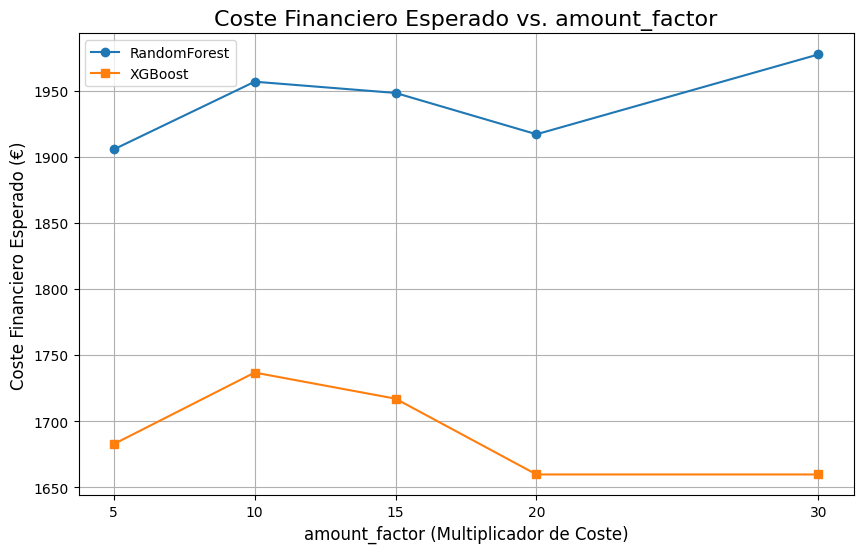

In [8]:
# Plot (código adaptado de compare_models.py)
plt.figure(figsize=(10, 6))
plt.plot(factors, rf_costs, 'o-', label='RandomForest')
plt.plot(factors, xgb_costs, 's-', label='XGBoost')
plt.title('Coste Financiero Esperado vs. amount_factor', fontsize=16)
plt.xlabel('amount_factor (Multiplicador de Coste)', fontsize=12)
plt.ylabel('Coste Financiero Esperado (€)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(factors)
plt.show()

## 4. Conclusión Final: La Mejor Estrategia Financiera

Los resultados de la simulación (celda 7) y la gráfica (celda 9) identifican la configuración ganadora. El criterio ya no es estadístico (AUPRC), sino puramente de negocio: **el coste mínimo en euros**.

**Hallazgos Clave:**

1.  **Mejor Modelo:** **XGBoost** es sistemáticamente superior a RandomForest, produciendo un coste financiero más bajo en todos los factores probados.
2.  **Factor Óptimo:** El coste de XGBoost se minimiza (toca fondo) en **€1,660** cuando el `amount_factor` es **20** y se mantiene igual con un factor de 30. Esto sugiere que penalizar el importe 20 veces es la estrategia de entrenamiento óptima.
3.  **Umbral Óptimo:** Es crucial observar que el mejor `amount_factor` (20) se alinea con un umbral de decisión óptimo de **0.7821** (no 0.5). Esto indica que el modelo se ha vuelto tan sensible que la mejor estrategia de negocio es solo actuar sobre las alertas de muy alta confianza.

**Conclusión Ganadora:** La estrategia óptima para este TFG es un **XGBoost** entrenado con **coste variable (`sample_weight`)** usando un **`amount_factor` de 20**, y aplicando un **umbral de decisión de 0.7821**.

In [9]:
# Encontrar la mejor configuración (código de compare_models.py)

# Encontrar el mejor factor para XGBoost (suele ser el mejor modelo)
best_f_xgb = factors[np.argmin(xgb_costs)]
min_cost_xgb = min(xgb_costs)

# Encontrar el mejor factor para Random Forest
best_f_rf = factors[np.argmin(rf_costs)]
min_cost_rf = min(rf_costs)

print("--- CONCLUSIÓN DEL ANÁLISIS FINANCIERO ---")
print(f"Mejor configuración para XGBoost:")
print(f"   amount_factor = {best_f_xgb}")
print(f"   Coste Mínimo Esperado: €{min_cost_xgb:,.0f}")
print("-" * 30)
print(f"Mejor configuración para RandomForest:")
print(f"   amount_factor = {best_f_rf}")
print(f"   Coste Mínimo Esperado: €{min_cost_rf:,.0f}")
print("-" * 30)

if min_cost_xgb < min_cost_rf:
    print(f"\\n🏆 GANADOR: XGBoost con amount_factor={best_f_xgb} (Coste: €{min_cost_xgb:,.0f})")
else:
    print(f"\\n🏆 GANADOR: RandomForest con amount_factor={best_f_rf} (Coste: €{min_cost_rf:,.0f})")

--- CONCLUSIÓN DEL ANÁLISIS FINANCIERO ---
Mejor configuración para XGBoost:
   amount_factor = 20
   Coste Mínimo Esperado: €1,660
------------------------------
Mejor configuración para RandomForest:
   amount_factor = 5
   Coste Mínimo Esperado: €1,905
------------------------------
\n🏆 GANADOR: XGBoost con amount_factor=20 (Coste: €1,660)
